In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import keras.backend as K
from PyQt5.QtWidgets import QFileDialog
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import image, load_img, img_to_array

%matplotlib inline
%gui qt

Using TensorFlow backend.


In [2]:
def open_dir(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None: dir ='./'
    fname = QFileDialog.getOpenFileName(None, "Select data file...", 
                dir, filter="All files (*);; SM Files (*.sm)")
    return fname[0]

In [15]:
IMG_PATH = open_dir()

In [16]:
IMG_PATH

'C:/Users/ASUS/Desktop/Archel/Nottingham/Dissertation/Source Code/xray-images/pneumonia-dataset/4451601jpg.jpg'

In [5]:
MODEL_PATH = open_dir()

In [6]:
MODEL_PATH

'C:/Users/ASUS/Desktop/Archel/Nottingham/Dissertation/Source Code/pneumonia_model_test.hdf5'

In [7]:
prediction_model = load_model(MODEL_PATH, compile=False)
prediction_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
x = load_img(IMG_PATH, target_size=(224,224))
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [18]:
pred = prediction_model.predict(x)
argmax = np.argmax(pred[0])
output = prediction_model.output[:, argmax]

In [19]:
# take the last convolutional layer
last_conv_layer = prediction_model.get_layer('block5_conv3')
# extract the gradients from the last convolutional layer against the class logits (np.argmax)
grads = K.gradients(output, last_conv_layer.output)[0]
# print(grads.shape)
# take the mean of the gradients, leaving us with the channel dimension --> global average pooling
pooled_grads = K.mean(grads, axis=(0,1,2))
# define a temporary model with pre-trained model as its input and the last convolutional layer as its output
i = K.function([prediction_model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = i([x])

In [20]:
# do the matrix multiplication to obtain weight between the last convolutional layer and its gradient
for l in range(64):
    conv_layer_output_value[:, :, l] *= pooled_grads_value[l]

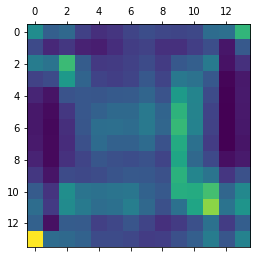

In [21]:
# average the weighted feature map along the channel dimension which resulting in a heatmap
heatmap = np.mean(conv_layer_output_value, axis=-1)
# normalize the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
# display the matrix values with matshow
plt.matshow(heatmap) 
plt.show()

In [22]:
confidence = pred[0, np.argmax(pred)]

Text(0.5,1,'Result:Pneumonia|Confidence:91.14149808883667')

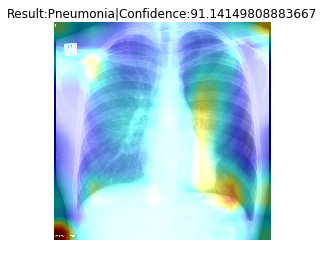

In [23]:
img = cv2.imread(IMG_PATH)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# multiply heatmap by 255 to convert it back to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

hif = .5 # intensity value

superimposed_img = heatmap * hif + img # paste the heatmap * intensity to the original image
output = 'output.jpeg'
cv2.imwrite(output, superimposed_img)
img=mpimg.imread(output)
plt.imshow(img)
plt.axis('off')
plt.title('Result:' + str('Normal' if pred[0,0] < 0.5 else 'Pneumonia') + '|' + 'Confidence:' + str(confidence * 100))